In [125]:
# Import Dependencies
import os
from multiprocessing import cpu_count

import matplotlib.pyplot as plt

import numpy as np

import mxnet as mx
from mxnet import ndarray as nd
from mxnet import gluon
from mxnet.gluon.data.vision import transforms
from mxnet import autograd


In [6]:
# Parameters and Hyperparameters
CPU_COUNT = cpu_count()

epochs = 5
batch_size = 64
learning_rate = 0.001
# Adam Optimizer params
b1 = 0.5
b2 = 0.999

latent_space_dimension = 100
image_size = 28
image_channels = 1
sample_interval = 400

In [8]:
image_shape = (image_channels, image_size, image_size)

In [11]:
ctx = mx.cpu() #Use mx.gpu(0) for GPU

In [97]:
# Generator Network
class Generator(gluon.Block):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = gluon.nn.Sequential()
        with self.model.name_scope():
            self.model.add(gluon.nn.Dense(256, in_units=latent_space_dimension))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.BatchNorm(momentum=0.8))
            self.model.add(gluon.nn.Dense(512))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.BatchNorm(momentum=0.8))
            self.model.add(gluon.nn.Dense(1024))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.BatchNorm(momentum=0.8))
            self.model.add(gluon.nn.Dense(np.prod(image_shape), activation='tanh'))
    
    def forward(self, X):
        img = self.model(X)
        
        return nd.reshape(img, shape=((X.shape[0],) + image_shape))
        

class Discriminator(gluon.Block):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = gluon.nn.Sequential()
        with self.model.name_scope():
            self.model.add(gluon.nn.Dense(512, in_units=np.prod(image_shape)))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.Dense(256, in_units=512))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.Dense(1, in_units=256))
    
    def forward(self, X):
        return self.model(nd.reshape(X, shape=(X.shape[0], -1)))

In [98]:
# Loss Functions
adversarial_loss = gluon.loss.SigmoidBCELoss()

In [99]:
generator = Generator()
discriminator = Discriminator()

In [100]:
# initialize the generator and the discriminator
generator.initialize(mx.init.Normal(0.02), ctx=ctx)
discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': learning_rate, 'beta1': b1, 'beta2': b2})
trainerD = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': learning_rate, 'beta1': b1, 'beta2': b2})


In [101]:
def transform(data, label):
    return nd.transpose(data.astype(np.float32), (2,0,1))/255, label.astype(np.float32)
train_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=True, transform=transform),
                                      batch_size, shuffle=True)
test_data = gluon.data.DataLoader(gluon.data.vision.MNIST(train=False, transform=transform),
                                     batch_size, shuffle=False)

[Epoch - 0] [Batch - 0] - Generator loss = 7.272, Discriminator loss = 0.182
Example fake Generated image


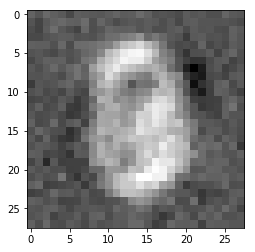

[Epoch - 0] [Batch - 100] - Generator loss = 11.670, Discriminator loss = 0.397
Example fake Generated image


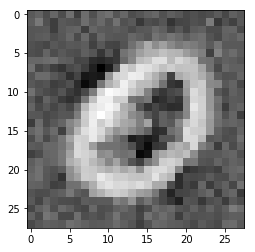

[Epoch - 0] [Batch - 200] - Generator loss = 4.982, Discriminator loss = 0.163
Example fake Generated image


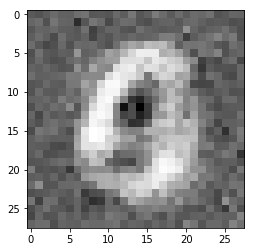

[Epoch - 0] [Batch - 300] - Generator loss = 8.466, Discriminator loss = 0.749
Example fake Generated image


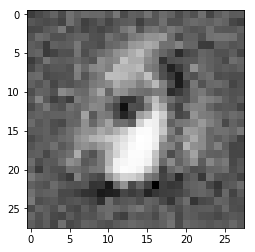

[Epoch - 0] [Batch - 400] - Generator loss = 10.052, Discriminator loss = 0.077
Example fake Generated image


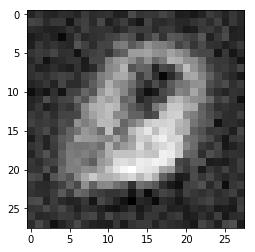

[Epoch - 0] [Batch - 500] - Generator loss = 7.791, Discriminator loss = 0.057
Example fake Generated image


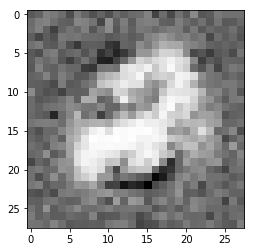

[Epoch - 0] [Batch - 600] - Generator loss = 10.576, Discriminator loss = 0.352
Example fake Generated image


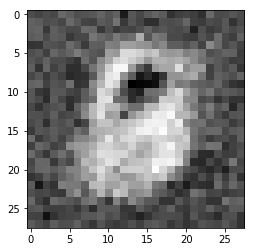

In [ ]:
smoothing_constant = 0.01

for e in range(epochs):
    for i, (real_imgs, label) in enumerate(train_data):
        real_imgs = real_imgs.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        # Adversarial ground truths
        valid = nd.ones(shape=(real_imgs.shape[0], 1))
        fake = nd.zeros(shape=(real_imgs.shape[0], 1))
        
        ############## Train Generator ################
        # Sample random noise for Generator Input
        z = nd.random.normal(loc=0, scale=1, shape=(real_imgs.shape[0], latent_space_dimension))
        
        with autograd.record():
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        trainerG.step(real_imgs.shape[0])
        
        ############# Train Discriminator ###############
        with autograd.record():
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        trainerD.step(real_imgs.shape[0])
        
        # Print loss infomation every 500 batches
        if i % 100 == 0:
            print('[Epoch - {}] [Batch - {}] - Generator loss = {:.3f}, Discriminator loss = {:.3f}'
                         .format(e, i, nd.mean(g_loss).asscalar(), nd.mean(d_loss).asscalar()))
            print('Example fake Generated image')
            # Choose a random image from generated image
            rand_index = np.random.randint(0, gen_imgs.shape[0])
            plt.imshow(gen_imgs[rand_index].asnumpy().reshape(28,28), cmap='gray')
            plt.show()